In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
import os, glob, shutil, math, time
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import History, CSVLogger, EarlyStopping

########################################################################
# This section rescales the data. For most ML models, we want to       #
# rescale so that we are analyzing data consistently (scale invariant) #
########################################################################
def data_rescale(scaled_dat,train_mean,train_var):
    d = np.shape(train_mean)[0]
    #print('unnormalizing with number of dimensions = ' +str(d))
    dat = (np.multiply(scaled_dat,np.sqrt(train_var))) + train_mean.T
    return(dat)
############################################################################
# Opposite to the above, normalizes the data based on some training values #
############################################################################
def data_normalize(data,train_mean,train_var):
    d = np.shape(train_mean)[0]
    print('normalizing with number of dimensions = ' +str(d))
    scaled_dat = np.divide((data - train_mean.T),np.sqrt(train_var),)
    return(scaled_dat)
    


In [5]:
data = pd.read_csv("/Users/adityanandy/BGU-workshop/Data/QM9/mu-qm-file.csv")

In [6]:
# forbid_names = ['comb_2_0']
# for forb in forbid_names:
#     data  =  data.loc[data['Unnamed: 0']  != forb]
print(data['u0'])

0        -0.631066
1        -0.441207
2        -0.339577
3        -0.614337
4        -0.480982
5        -0.571716
6        -1.068970
7        -0.766693
8        -1.068141
9        -0.939926
10       -1.028397
11       -0.864757
12       -1.509975
13       -1.212970
14       -1.200600
15       -1.282844
16       -0.983347
17       -1.481807
18       -1.315953
19       -1.141296
20       -1.952528
21       -1.660153
22       -1.072212
23       -0.933308
24       -0.787267
25       -1.019190
26       -0.879601
27       -0.975537
28       -1.520215
29       -1.508619
            ...   
133855   -2.735116
133856   -2.984682
133857   -2.727081
133858   -2.778933
133859   -2.691604
133860   -2.959853
133861   -2.927256
133862   -3.166465
133863   -2.906811
133864   -2.714148
133865   -2.620268
133866   -2.984697
133867   -3.277457
133868   -2.973493
133869   -2.682754
133870   -2.695881
133871   -2.780896
133872   -3.061731
133873   -2.757616
133874   -2.755437
133875   -2.871581
133876   -3.

In [8]:
## seed 
np.random.seed(4)
# get random partition
msk = np.random.rand(np.shape(data)[0]) < 0.01 

# test and train split
first_train_data = data[msk]
test_data = data[~msk]

# train and val split
val_msk = np.random.rand(np.shape(first_train_data)[0]) < 0.80
train_data = first_train_data[val_msk]
val_data = first_train_data[~val_msk]

In [9]:
# get 
feature_names=[]
for ft in data.columns:
    if ft.find('u0') ==-1  and ft.find('runs') ==-1 and ft.find('mu') ==-1:
            feature_names.append(ft)
print(feature_names)

['f-chi-0-all', 'f-chi-1-all', 'f-chi-2-all', 'f-chi-3-all', 'f-Z-0-all', 'f-Z-1-all', 'f-Z-2-all', 'f-Z-3-all', 'f-I-0-all', 'f-I-1-all', 'f-I-2-all', 'f-I-3-all', 'f-T-0-all', 'f-T-1-all', 'f-T-2-all', 'f-T-3-all', 'f-S-0-all', 'f-S-1-all', 'f-S-2-all', 'f-S-3-all']


In [10]:
variable = 'mu'
train_data_y = train_data[variable]
test_data_y = test_data[variable]
val_data_y = val_data[variable]
# xvales
train_data_x = train_data[feature_names].values
test_data_x = test_data[feature_names].values
val_data_x = val_data[feature_names].values
## data generation
m = np.shape(train_data_x)[0]
d = np.shape(train_data_x)[1]
p = 1
# normalization
train_var_x = np.var(train_data_x,0)
train_mean_x = np.mean(train_data_x,0).reshape(d,1).squeeze()
train_var_y = np.var(train_data_y,0).reshape(1)
train_mean_y = np.mean(train_data_y,0).reshape(1)
# scale
scaled_train_data_x = data_normalize(train_data_x,train_mean_x,train_var_x)
scaled_train_data_y = data_normalize(train_data_y,train_mean_y,train_var_y)
scaled_test_data_x = data_normalize(test_data_x,train_mean_x,train_var_x)
scaled_test_data_y = data_normalize(test_data_y,train_mean_y,train_var_y)
scaled_val_data_x = data_normalize(val_data_x,train_mean_x,train_var_x)
scaled_val_data_y = data_normalize(val_data_y,train_mean_y,train_var_y)

normalizing with number of dimensions = 20
normalizing with number of dimensions = 1
normalizing with number of dimensions = 20
normalizing with number of dimensions = 1
normalizing with number of dimensions = 20
normalizing with number of dimensions = 1


In [17]:
def prepare_architecture(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    print(model.summary())
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=["mae"])
    return model

def train_model(model, x_train, y_train, x_val, y_val,epochs, verbose=True):
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=500, verbose=1, mode='auto')
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=50, validation_data=(x_val, y_val),
            callbacks=[earlystop], verbose=verbose)
    return model, history

In [24]:
layers = [Dense(300, input_dim=20, kernel_initializer='normal', activation='relu',kernel_regularizer = l2(1e-06)),
          Dropout(0.10, noise_shape=None, seed=None),
          Dense(300, kernel_initializer='normal', activation='relu', kernel_regularizer = l2(1e-06)),
          Dropout(0.10, noise_shape=None, seed=None), 
          Dense(1,activation='linear')]
model = prepare_architecture(layers)
trained_model, history = train_model(model,scaled_train_data_x,scaled_train_data_y,
                                            scaled_val_data_x,scaled_val_data_y,2000)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 300)               6300      
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 301       
Total params: 96,901
Trainable params: 96,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 1062 samples, validate on 256 samples
Epoch 1/2000
1062/1062 [==============================] - 1s - loss: 0.8679 - mean_abs

1062/1062 [==============================] - 0s - loss: 0.4618 - mean_absolute_error: 0.5206 - val_loss: 1.1501 - val_mean_absolute_error: 0.6571
Epoch 46/2000
1062/1062 [==============================] - 0s - loss: 0.4752 - mean_absolute_error: 0.5368 - val_loss: 1.1995 - val_mean_absolute_error: 0.6516
Epoch 47/2000
1062/1062 [==============================] - 0s - loss: 0.4464 - mean_absolute_error: 0.5133 - val_loss: 1.1513 - val_mean_absolute_error: 0.6527
Epoch 48/2000
1062/1062 [==============================] - 0s - loss: 0.4420 - mean_absolute_error: 0.5181 - val_loss: 1.1760 - val_mean_absolute_error: 0.6470
Epoch 49/2000
1062/1062 [==============================] - 0s - loss: 0.4390 - mean_absolute_error: 0.5119 - val_loss: 1.1399 - val_mean_absolute_error: 0.6434
Epoch 50/2000
1062/1062 [==============================] - 0s - loss: 0.4149 - mean_absolute_error: 0.5042 - val_loss: 1.1757 - val_mean_absolute_error: 0.6660
Epoch 51/2000
1062/1062 [=============================

1062/1062 [==============================] - 0s - loss: 0.2899 - mean_absolute_error: 0.4067 - val_loss: 1.2140 - val_mean_absolute_error: 0.6585
Epoch 97/2000
1062/1062 [==============================] - 0s - loss: 0.2882 - mean_absolute_error: 0.4084 - val_loss: 1.2075 - val_mean_absolute_error: 0.6559
Epoch 98/2000
1062/1062 [==============================] - 0s - loss: 0.2849 - mean_absolute_error: 0.4052 - val_loss: 1.1800 - val_mean_absolute_error: 0.6454
Epoch 99/2000
1062/1062 [==============================] - 0s - loss: 0.2867 - mean_absolute_error: 0.4051 - val_loss: 1.2137 - val_mean_absolute_error: 0.6462
Epoch 100/2000
1062/1062 [==============================] - 0s - loss: 0.2993 - mean_absolute_error: 0.4163 - val_loss: 1.2076 - val_mean_absolute_error: 0.6509
Epoch 101/2000
1062/1062 [==============================] - 0s - loss: 0.2856 - mean_absolute_error: 0.4159 - val_loss: 1.1980 - val_mean_absolute_error: 0.6480
Epoch 102/2000
1062/1062 [==========================

1062/1062 [==============================] - 0s - loss: 0.1929 - mean_absolute_error: 0.3308 - val_loss: 1.2689 - val_mean_absolute_error: 0.6774
Epoch 147/2000
1062/1062 [==============================] - 0s - loss: 0.2094 - mean_absolute_error: 0.3414 - val_loss: 1.2516 - val_mean_absolute_error: 0.6872
Epoch 148/2000
1062/1062 [==============================] - 0s - loss: 0.2178 - mean_absolute_error: 0.3501 - val_loss: 1.2614 - val_mean_absolute_error: 0.6706
Epoch 149/2000
1062/1062 [==============================] - 0s - loss: 0.2104 - mean_absolute_error: 0.3402 - val_loss: 1.2383 - val_mean_absolute_error: 0.6777
Epoch 150/2000
1062/1062 [==============================] - 0s - loss: 0.2116 - mean_absolute_error: 0.3368 - val_loss: 1.2244 - val_mean_absolute_error: 0.6597
Epoch 151/2000
1062/1062 [==============================] - 0s - loss: 0.1998 - mean_absolute_error: 0.3316 - val_loss: 1.2556 - val_mean_absolute_error: 0.6717
Epoch 152/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.1521 - mean_absolute_error: 0.2926 - val_loss: 1.2814 - val_mean_absolute_error: 0.6647
Epoch 197/2000
1062/1062 [==============================] - 0s - loss: 0.1316 - mean_absolute_error: 0.2727 - val_loss: 1.2331 - val_mean_absolute_error: 0.6712
Epoch 198/2000
1062/1062 [==============================] - 0s - loss: 0.1347 - mean_absolute_error: 0.2734 - val_loss: 1.2762 - val_mean_absolute_error: 0.6789
Epoch 199/2000
1062/1062 [==============================] - 0s - loss: 0.1418 - mean_absolute_error: 0.2781 - val_loss: 1.2727 - val_mean_absolute_error: 0.6781
Epoch 200/2000
1062/1062 [==============================] - 0s - loss: 0.1379 - mean_absolute_error: 0.2749 - val_loss: 1.2538 - val_mean_absolute_error: 0.6781
Epoch 201/2000
1062/1062 [==============================] - 0s - loss: 0.1486 - mean_absolute_error: 0.2869 - val_loss: 1.2704 - val_mean_absolute_error: 0.6797
Epoch 202/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.1048 - mean_absolute_error: 0.2451 - val_loss: 1.2430 - val_mean_absolute_error: 0.6767
Epoch 247/2000
1062/1062 [==============================] - 0s - loss: 0.1060 - mean_absolute_error: 0.2432 - val_loss: 1.3032 - val_mean_absolute_error: 0.6837
Epoch 248/2000
1062/1062 [==============================] - 0s - loss: 0.1315 - mean_absolute_error: 0.2635 - val_loss: 1.2451 - val_mean_absolute_error: 0.6863
Epoch 249/2000
1062/1062 [==============================] - 0s - loss: 0.1241 - mean_absolute_error: 0.2564 - val_loss: 1.2701 - val_mean_absolute_error: 0.6829
Epoch 250/2000
1062/1062 [==============================] - 0s - loss: 0.1002 - mean_absolute_error: 0.2385 - val_loss: 1.2869 - val_mean_absolute_error: 0.6885
Epoch 251/2000
1062/1062 [==============================] - 0s - loss: 0.1164 - mean_absolute_error: 0.2570 - val_loss: 1.2919 - val_mean_absolute_error: 0.6898
Epoch 252/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.0943 - mean_absolute_error: 0.2297 - val_loss: 1.2941 - val_mean_absolute_error: 0.6913
Epoch 297/2000
1062/1062 [==============================] - 0s - loss: 0.1055 - mean_absolute_error: 0.2366 - val_loss: 1.2926 - val_mean_absolute_error: 0.6824
Epoch 298/2000
1062/1062 [==============================] - 0s - loss: 0.0935 - mean_absolute_error: 0.2262 - val_loss: 1.2822 - val_mean_absolute_error: 0.6855
Epoch 299/2000
1062/1062 [==============================] - 0s - loss: 0.0980 - mean_absolute_error: 0.2378 - val_loss: 1.2921 - val_mean_absolute_error: 0.6852
Epoch 300/2000
1062/1062 [==============================] - 0s - loss: 0.0936 - mean_absolute_error: 0.2291 - val_loss: 1.2922 - val_mean_absolute_error: 0.6998
Epoch 301/2000
1062/1062 [==============================] - 0s - loss: 0.1003 - mean_absolute_error: 0.2351 - val_loss: 1.2976 - val_mean_absolute_error: 0.6779
Epoch 302/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.0860 - mean_absolute_error: 0.2189 - val_loss: 1.2679 - val_mean_absolute_error: 0.6928
Epoch 347/2000
1062/1062 [==============================] - 0s - loss: 0.0840 - mean_absolute_error: 0.2143 - val_loss: 1.2754 - val_mean_absolute_error: 0.6969
Epoch 348/2000
1062/1062 [==============================] - 0s - loss: 0.0923 - mean_absolute_error: 0.2231 - val_loss: 1.2952 - val_mean_absolute_error: 0.6982
Epoch 349/2000
1062/1062 [==============================] - 0s - loss: 0.0904 - mean_absolute_error: 0.2238 - val_loss: 1.2638 - val_mean_absolute_error: 0.6743
Epoch 350/2000
1062/1062 [==============================] - 0s - loss: 0.0931 - mean_absolute_error: 0.2258 - val_loss: 1.3056 - val_mean_absolute_error: 0.6880
Epoch 351/2000
1062/1062 [==============================] - 0s - loss: 0.0862 - mean_absolute_error: 0.2172 - val_loss: 1.2674 - val_mean_absolute_error: 0.6907
Epoch 352/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.0850 - mean_absolute_error: 0.2141 - val_loss: 1.3144 - val_mean_absolute_error: 0.7031
Epoch 397/2000
1062/1062 [==============================] - 0s - loss: 0.0766 - mean_absolute_error: 0.2036 - val_loss: 1.3094 - val_mean_absolute_error: 0.6948
Epoch 398/2000
1062/1062 [==============================] - 0s - loss: 0.0824 - mean_absolute_error: 0.2124 - val_loss: 1.3340 - val_mean_absolute_error: 0.7136
Epoch 399/2000
1062/1062 [==============================] - 0s - loss: 0.0830 - mean_absolute_error: 0.2051 - val_loss: 1.3036 - val_mean_absolute_error: 0.7077
Epoch 400/2000
1062/1062 [==============================] - 0s - loss: 0.0683 - mean_absolute_error: 0.1968 - val_loss: 1.3329 - val_mean_absolute_error: 0.6966
Epoch 401/2000
1062/1062 [==============================] - 0s - loss: 0.0686 - mean_absolute_error: 0.1946 - val_loss: 1.3311 - val_mean_absolute_error: 0.6965
Epoch 402/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.0615 - mean_absolute_error: 0.1841 - val_loss: 1.3014 - val_mean_absolute_error: 0.7019
Epoch 447/2000
1062/1062 [==============================] - 0s - loss: 0.0623 - mean_absolute_error: 0.1827 - val_loss: 1.2884 - val_mean_absolute_error: 0.7022
Epoch 448/2000
1062/1062 [==============================] - 0s - loss: 0.0691 - mean_absolute_error: 0.1926 - val_loss: 1.2903 - val_mean_absolute_error: 0.6970
Epoch 449/2000
1062/1062 [==============================] - 0s - loss: 0.0671 - mean_absolute_error: 0.1889 - val_loss: 1.2787 - val_mean_absolute_error: 0.6823
Epoch 450/2000
1062/1062 [==============================] - 0s - loss: 0.0742 - mean_absolute_error: 0.1965 - val_loss: 1.3024 - val_mean_absolute_error: 0.7039
Epoch 451/2000
1062/1062 [==============================] - 0s - loss: 0.0578 - mean_absolute_error: 0.1796 - val_loss: 1.3592 - val_mean_absolute_error: 0.7145
Epoch 452/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.0578 - mean_absolute_error: 0.1755 - val_loss: 1.3170 - val_mean_absolute_error: 0.6905
Epoch 497/2000
1062/1062 [==============================] - 0s - loss: 0.0633 - mean_absolute_error: 0.1850 - val_loss: 1.3067 - val_mean_absolute_error: 0.6925
Epoch 498/2000
1062/1062 [==============================] - 0s - loss: 0.0631 - mean_absolute_error: 0.1801 - val_loss: 1.3171 - val_mean_absolute_error: 0.6954
Epoch 499/2000
1062/1062 [==============================] - 0s - loss: 0.0639 - mean_absolute_error: 0.1837 - val_loss: 1.2901 - val_mean_absolute_error: 0.6933
Epoch 500/2000
1062/1062 [==============================] - 0s - loss: 0.0620 - mean_absolute_error: 0.1810 - val_loss: 1.3082 - val_mean_absolute_error: 0.6880
Epoch 501/2000
1062/1062 [==============================] - 0s - loss: 0.0692 - mean_absolute_error: 0.1904 - val_loss: 1.3091 - val_mean_absolute_error: 0.7065
Epoch 502/2000
1062/1062 [=======================

1062/1062 [==============================] - 0s - loss: 0.0678 - mean_absolute_error: 0.1927 - val_loss: 1.3128 - val_mean_absolute_error: 0.6953
Epoch 547/2000
1062/1062 [==============================] - 0s - loss: 0.0788 - mean_absolute_error: 0.1970 - val_loss: 1.2994 - val_mean_absolute_error: 0.6901
Epoch 548/2000
1062/1062 [==============================] - 0s - loss: 0.0730 - mean_absolute_error: 0.1962 - val_loss: 1.3160 - val_mean_absolute_error: 0.6872
Epoch 549/2000
1062/1062 [==============================] - 0s - loss: 0.0653 - mean_absolute_error: 0.1840 - val_loss: 1.3115 - val_mean_absolute_error: 0.6964
Epoch 550/2000
1062/1062 [==============================] - 0s - loss: 0.0655 - mean_absolute_error: 0.1887 - val_loss: 1.2849 - val_mean_absolute_error: 0.6829
Epoch 551/2000
1062/1062 [==============================] - 0s - loss: 0.0638 - mean_absolute_error: 0.1834 - val_loss: 1.3164 - val_mean_absolute_error: 0.6955
Epoch 552/2000
1062/1062 [=======================

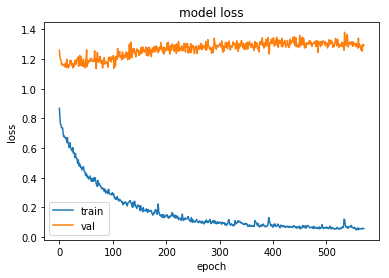

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

Text(0,0.5,'pred')

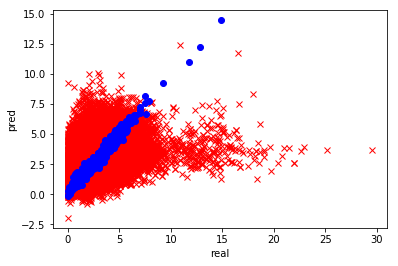

In [27]:
pred_train = data_rescale(model.predict(scaled_train_data_x),train_mean_y,train_var_y)
real_train =  data_rescale(scaled_train_data_y,train_mean_y,train_var_y)
pred_test = data_rescale(model.predict(scaled_test_data_x),train_mean_y,train_var_y)
real_test =  data_rescale(scaled_test_data_y,train_mean_y,train_var_y)
plt.plot(real_test,pred_test,'rx')
plt.plot(real_train,pred_train,'bo')
plt.xlabel('real')
plt.ylabel('pred')